# Dog Breed Classification with ResNet18

This notebook presents a **deep learning project** where I classify **15 dog breeds** using transfer learning with **ResNet-18**.  
The workflow includes data preparation, augmentation strategies, model training with early stopping, and evaluation through classification reports, confusion matrices, and F1-scores.

**Objective:** develop a reliable image classifier and compare different training strategies in order to select the best-performing model.

### Dog Breeds Classes

| #  | Breed                   |
|----|--------------------------|
| 1  | Blenheim_spaniel         |
| 2  | Border_terrier           |
| 3  | Chihuahua                |
| 4  | Japanese_spaniel         |
| 5  | Lakeland_terrier         |
| 6  | Maltese_dog              |
| 7  | Norfolk_terrier          |
| 8  | Pekinese                 |
| 9  | Sealyham_terrier         |
| 10 | Shih-Tzu                 |
| 11 | Yorkshire_terrier        |
| 12 | cairn                    |
| 13 | papillon                 |
| 14 | toy_terrier              |
| 15 | wire-haired_fox_terrier  |



**Data organization**
- Train / Validation / Test split in **Images** Folder:

In [1]:
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, models, transforms

In [ ]:
BATCH_SIZE = 64 if torch.cuda.is_available() else 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_PIN_MEMORY = torch.cuda.is_available()
DATA_DIR = r"C:\Users\User\OneDrive\Bureau\Projects\CV_AI_DETECTION\Images"
NUM_WORKERS = os.cpu_count()

print("Using device:", DEVICE)

Using device: cpu


## 1. Data Preprocessing & Augmentation



### Model 1 Summary
For Model 1, I implemented a **baseline training pipeline** using ResNet-18 with ImageNet pre-trained weights.  
I replaced the final fully connected layer to match the number of dog breeds in my dataset.  
The training data was augmented with moderate transformations, including random resized cropping, horizontal flipping, and light color jittering (brightness, contrast, and saturation).  
Validation and test data were only resized and center-cropped to ensure consistent evaluation.  
This model provided a **stable benchmark** to measure the effectiveness of more advanced augmentation strategies.

In [ ]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
                  for x in ["train", "val", "test"]}

class_names = image_datasets["train"].classes
print("Classes :", class_names)
class_names = image_datasets["train"].classes
NUM_CLASSES = len(class_names)
print("NUM_CLASSES =", NUM_CLASSES)

dataloaders = {
    x: DataLoader(image_datasets[x],
                  batch_size=BATCH_SIZE,
                  shuffle=(x == "train"),  # shuffle seulement pour train
                  num_workers=NUM_WORKERS,
                  pin_memory=USE_PIN_MEMORY)
    for x in ["train", "val", "test"]
}

Classes : ['Blenheim_spaniel', 'Border_terrier', 'Chihuahua', 'Japanese_spaniel', 'Lakeland_terrier', 'Maltese_dog', 'Norfolk_terrier', 'Pekinese', 'Sealyham_terrier', 'Shih-Tzu', 'Yorkshire_terrier', 'cairn', 'papillon', 'toy_terrier', 'wire-haired_fox_terrier']
NUM_CLASSES = 15


### Model 2 Summary
For Model 2, I extended the baseline by introducing a **stronger augmentation strategy** to increase robustness.  
In addition to the augmentations from Model 1, I applied controlled random rotations, small affine translations, and random erasing with limited probability and scale.  
The idea was to expose the model to more diverse visual conditions, simulating variations such as viewpoint changes and partial occlusions.  
As with Model 1, the network backbone was ResNet-18 pre-trained on ImageNet, with the final layer adapted to my classes.  
This approach aimed to **improve generalization**, particularly for breeds that are harder to classify consistently.

In [ ]:
data_transforms_2 = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),  # réduit de 15 → 10
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # réduit la translation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # réduit l'intensité
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.15))  # réduit la proba + taille
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
image_datasets_2 = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms_2[x])
                  for x in ["train", "val", "test"]}

dataloaders_2 = {
    x: DataLoader(image_datasets_2[x],
                  batch_size=BATCH_SIZE,
                  shuffle=(x == "train"),  # shuffle seulement pour train
                  num_workers=NUM_WORKERS,
                  pin_memory=USE_PIN_MEMORY)
    for x in ["train", "val", "test"]
}

### Comparative Summary

The two models were designed to evaluate the impact of different augmentation strategies on classification performance:

- **Model 1** established a baseline using moderate augmentations (cropping, flipping, and light color jitter). It provided a stable point of reference for measuring improvements.  
- **Model 2** extended this baseline with stronger augmentations (rotation, affine translations, and random erasing) in order to simulate more realistic variations and potential occlusions.

By comparing these two approaches, I aimed to understand whether stronger augmentation leads to better generalization and improved performance across all dog breeds.

## 2. Model Architecture & Training Setup

### 2.1 Common Backbone (Both Models)
- **Base architecture:** ResNet-18 pre-trained on ImageNet (`weights="IMAGENET1K_V1"`).
- **Head adaptation:** Replace the final FC layer with `Linear(num_ftrs, NUM_CLASSES)` for **15 dog breeds**.
- **Loss:** `CrossEntropyLoss`.
- **Optimizer:** `Adam(lr=1e-4)`.
- **Evaluation pipeline (val/test):** `Resize(256) → CenterCrop(224) → ToTensor → Normalize`.

> In other words, **both models share the same network, loss, and optimizer**. They differ in **data augmentation** and **learning-rate scheduling**.

In [35]:
PATIENCE = 4
MIN_DELTA = 1e-4
EXCELLENT_ACC = 0.995
EXCELLENT_LOSS = 0.03
EXCELLENT_ROUNDS = 2

### 2.2 Model 1 — Baseline (Moderate Augmentation, No LR Scheduler)
**Objective:** Establish a stable baseline close to the original data distribution.

**Training setup**
- **LR:** fixed at `1e-4` (no scheduler).
- **Dataloaders:** shuffle for `train`, standard eval transforms for `val/test`.

In [34]:
EPOCHS = 10
model = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### 2.3 Model 2 — Enhanced Augmentation + Cosine LR

**Objective:**  
Improve generalization by exposing the model to controlled geometric changes and mild occlusions, and apply a cosine learning rate decay during training.

**Training setup:**
- **Learning rate scheduler:** `CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)`  
  → applied with `scheduler.step()` once per epoch.  
- **Dataloaders:** shuffle enabled only for the training set; validation and test transforms kept identical to Model 1 for fair comparison.

In [33]:
EPOCHS_2 = 20
model_2 = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs_2 = model_2.fc.in_features
model_2.fc = nn.Linear(num_ftrs_2, NUM_CLASSES)
model_2 = model_2.to(DEVICE)

criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR( optimizer_2, T_max=EPOCHS_2, eta_min=1e-6 )

## 3. Training Strategy

### 3.1 Common Training Logic
Both models share a common backbone for the training loop:

- **Phases:** each epoch includes a `train` and a `val` phase, switching between `model.train()` and `model.eval()`.
- **Optimization:** forward pass → loss computation → backward pass → parameter update (only during `train`).
- **Metrics:** per-phase aggregation of loss and accuracy, stored in the `history` object.
- **Early stopping:**  
  - **Patience = 2** → stop if validation loss does not improve after 2 consecutive epochs.  
  - **Min Delta = 1e-4** → minimum improvement required to reset patience.  
  - **Excellent Metrics Threshold:**  
    - Validation Accuracy ≥ **99.5%**  
    - Validation Loss ≤ **0.03**  
    - Reached for at least 2 consecutive epochs triggers an early stop.
- **Checkpointing:** the best model weights (lowest validation loss) are saved to disk and reloaded at the end of training.

> In short, both models rely on the same control flow, early stopping logic, and checkpointing policy. They only differ in learning-rate management and data augmentation.

---

### 3.2 Model 1 — Baseline Training Loop
The **baseline loop (`train_model_baseline`)** establishes a stable reference.

- **Learning rate:** fixed at `1e-4` (no scheduler).  
- **Dataloaders:** shuffled only for the training set; validation and test use fixed order.  
- **Checkpointing:** best weights are saved to `./Models/resnet18_best_baseline.pth`.

This setup allows assessing performance under moderate augmentation and a fixed LR policy.




In [ ]:
def train_model_baseline(model, criterion, optimizer, num_epochs=EPOCHS, save_path="./Models/resnet18_best_baseline.pth"):
    best_weights = deepcopy(model.state_dict())
    best_val_loss = float("inf")
    best_epoch = -1

    patience_counter = 0
    streak = 0

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss, running_corrects, n_samples = 0.0, 0, 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                bs = inputs.size(0)
                running_loss += loss.item() * bs
                running_corrects += (preds == labels).sum()
                n_samples += bs

            epoch_loss = running_loss / n_samples
            epoch_acc = (running_corrects.double() / n_samples).item()

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)
            print(f"{phase}: loss={epoch_loss:.4f}, acc={epoch_acc:.4f}")

        val_loss, val_acc = history["val_loss"][-1], history["val_acc"][-1]

        if val_loss < best_val_loss - MIN_DELTA:
            best_val_loss = val_loss
            best_epoch = epoch
            best_weights = deepcopy(model.state_dict())
            torch.save(best_weights, save_path)
            patience_counter = 0
        else:
            patience_counter += 1

        if val_acc >= EXCELLENT_ACC and val_loss <= EXCELLENT_LOSS:
            streak += 1
        else:
            streak = 0

        if streak >= EXCELLENT_ROUNDS:
            print(f"Early stop: excellent metrics at epoch {epoch+1}")
            break
        if patience_counter >= PATIENCE:
            print(f"Early stop: no val_loss improvement at epoch {epoch+1}")
            break

    model.load_state_dict(best_weights)
    print(f"Loaded best (epoch {best_epoch+1}, val_loss={best_val_loss:.4f})")
    return model, history

model, history = train_model_baseline(model, criterion, optimizer, num_epochs=EPOCHS)


Epoch 1/10
train: loss=1.5737, acc=0.5497
val: loss=0.5729, acc=0.8182

Epoch 2/10
train: loss=0.8305, acc=0.7627
val: loss=0.3948, acc=0.8821

Epoch 3/10
train: loss=0.6546, acc=0.8130
val: loss=0.3693, acc=0.8894

Epoch 4/10
train: loss=0.5979, acc=0.8150
val: loss=0.4100, acc=0.8698

Epoch 5/10
train: loss=0.4944, acc=0.8513
val: loss=0.3372, acc=0.8870

Epoch 6/10
train: loss=0.4605, acc=0.8591
val: loss=0.3126, acc=0.8968

Epoch 7/10
train: loss=0.4179, acc=0.8777
val: loss=0.3098, acc=0.9042

Epoch 8/10
train: loss=0.3924, acc=0.8767
val: loss=0.3204, acc=0.8870

Epoch 9/10
train: loss=0.3981, acc=0.8803
val: loss=0.3037, acc=0.9140

Epoch 10/10
train: loss=0.4051, acc=0.8819
val: loss=0.3715, acc=0.8673
Loaded best (epoch 9, val_loss=0.3037)


---

### 3.3 Model 2 — Enhanced Training Loop
The **enhanced loop (`train_model_enhanced`)** extends the baseline with a cosine learning-rate decay.

- **Learning rate schedule:**  
  - `CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)`  
  - Stepped once per epoch (`scheduler.step()`).
- **LR tracking:** the effective learning rate is logged in `history["lr"]` at each epoch.  
- **Checkpointing:** best weights are saved to `resnet18_best_baseline_augmentation_scheduler_2.pth`.

This setup pairs stronger augmentations with smooth LR decay to improve generalization while keeping convergence stable.

In [ ]:
def train_model_enhanced(model, criterion, optimizer, scheduler, num_epochs=EPOCHS_2, save_path="./Models/resnet18_best_baseline_enhanced.pth"):
    best_weights = deepcopy(model.state_dict())
    best_val_loss = float("inf")
    best_epoch = -1

    patience_counter = 0
    streak = 0

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss, running_corrects, n_samples = 0.0, 0, 0

            for inputs, labels in dataloaders_2[phase]:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                bs = inputs.size(0)
                running_loss += loss.item() * bs
                running_corrects += (preds == labels).sum()
                n_samples += bs

            epoch_loss = running_loss / n_samples
            epoch_acc = (running_corrects.double() / n_samples).item()

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)
            print(f"{phase}: loss={epoch_loss:.4f}, acc={epoch_acc:.4f}")

        scheduler.step()
        history["lr"].append(optimizer.param_groups[0]["lr"])

        val_loss, val_acc = history["val_loss"][-1], history["val_acc"][-1]

        if val_loss < best_val_loss - MIN_DELTA:
            best_val_loss = val_loss
            best_epoch = epoch
            best_weights = deepcopy(model.state_dict())
            torch.save(best_weights, save_path)
            patience_counter = 0
        else:
            patience_counter += 1

        if val_acc >= EXCELLENT_ACC and val_loss <= EXCELLENT_LOSS:
            streak += 1
        else:
            streak = 0

        if streak >= EXCELLENT_ROUNDS:
            print(f"Early stop: excellent metrics at epoch {epoch+1}")
            break
        if patience_counter >= PATIENCE:
            print(f"Early stop: no val_loss improvement at epoch {epoch+1}")
            break

    model.load_state_dict(best_weights)
    print(f"Loaded best (epoch {best_epoch+1}, val_loss={best_val_loss:.4f})")
    return model, history

model_2, history_2 = train_model_enhanced(model_2, criterion_2, optimizer_2, scheduler, num_epochs=EPOCHS_2)


Epoch 1/20
train: loss=0.8254, acc=0.7642
val: loss=0.4760, acc=0.8526

Epoch 2/20
train: loss=0.6711, acc=0.8062
val: loss=0.3932, acc=0.8722

Epoch 3/20
train: loss=0.5943, acc=0.8337
val: loss=0.3829, acc=0.8845

Epoch 4/20
train: loss=0.5327, acc=0.8430
val: loss=0.3408, acc=0.8919

Epoch 5/20
train: loss=0.4447, acc=0.8699
val: loss=0.3226, acc=0.8919

Epoch 6/20
train: loss=0.4358, acc=0.8684
val: loss=0.3184, acc=0.8894

Epoch 7/20
train: loss=0.3854, acc=0.8891
val: loss=0.3229, acc=0.8943

Epoch 8/20
train: loss=0.3702, acc=0.8870
val: loss=0.3287, acc=0.8943
Early stop: no val_loss improvement at epoch 8
Loaded best (epoch 6, val_loss=0.3184)


## 4. Training and Validation Curves

To evaluate training dynamics, I monitored **loss** and **accuracy** across epochs for both the training and validation sets.  
This helps assess convergence speed, detect potential overfitting, and measure generalization performance.

---

### 4.1 Model 1 — Baseline (Moderate Augmentation, Fixed LR)

- **Loss Curve:** shows a consistent decrease for both training and validation sets, indicating stable optimization.  
- **Accuracy Curve:** validation accuracy improves rapidly and stabilizes around ~90%, while training accuracy gradually catches up.  

Overall, the baseline model demonstrates **solid convergence without major overfitting**, but its validation performance plateaus relatively early.


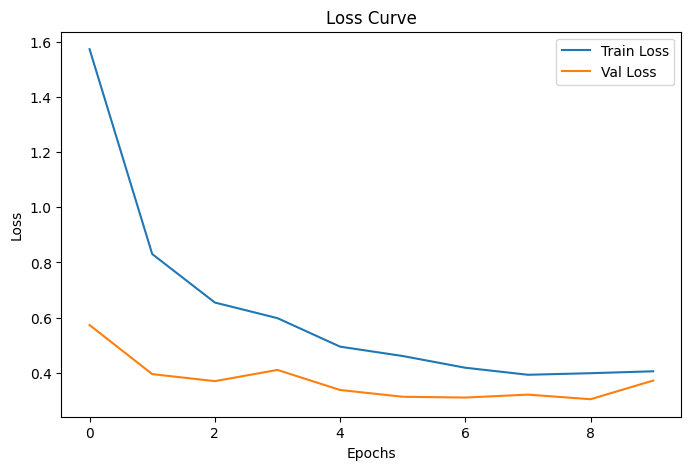

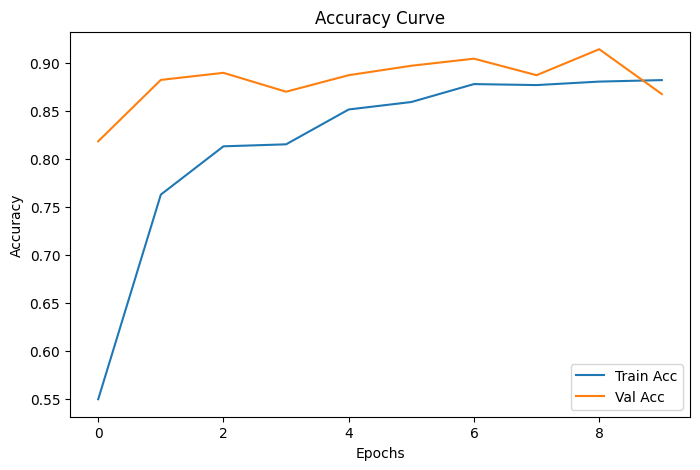

In [10]:
plt.figure(figsize=(8,5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()

### 4.2 Model 2 — Enhanced Augmentation + Cosine LR

- **Loss Curve:** training and validation loss decrease steadily, with validation loss remaining consistently lower than training loss.  
- **Accuracy Curve:** validation accuracy climbs faster and remains above training accuracy, peaking near ~89%.  

This indicates that the model **generalizes well under stronger augmentations** and benefits from the cosine learning rate schedule for smoother convergence.

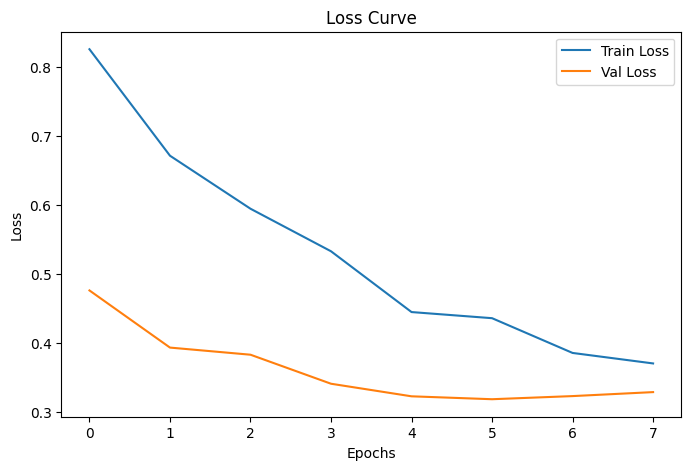

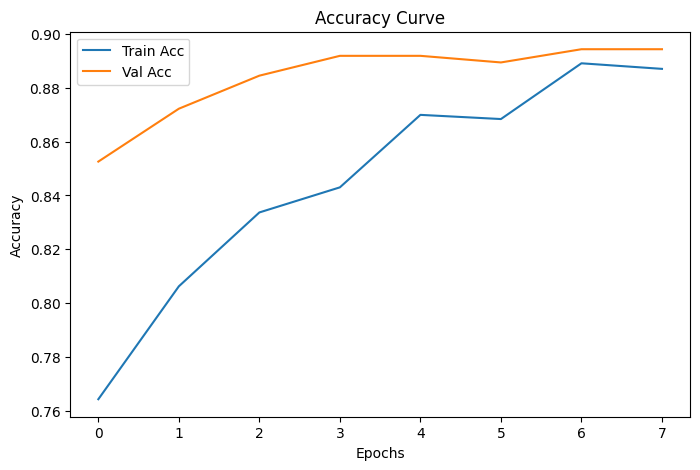

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history_2["train_loss"], label="Train Loss")
plt.plot(history_2["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history_2["train_acc"], label="Train Acc")
plt.plot(history_2["val_acc"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()

### 4.3 Comparison

- **Both models** achieve strong results with no significant overfitting.  
- **Model 1** provides a strong baseline with stable training behavior.  
- **Model 2** achieves slightly **better validation consistency and generalization**, making it the preferred choice for final deployment.

## 5. Model Evaluation  

After training both models, I evaluated them on the **held-out test set** to assess generalization performance across the 15 dog breeds.  

### 5.1 Evaluation Metrics  
For both models, I computed:  
- **Classification Report**: Precision, Recall, and F1-score per class.  
- **Confusion Matrix**: Visualization of misclassifications to identify where breeds are most often confused.  

---

### 5.2 Model 1 — Baseline (Moderate Augmentation, Fixed LR)  
**Results (Test Set):**  
- **Accuracy:** 0.89  
- **Macro F1-score:** 0.89  
- Strong performance on breeds like *Maltese_dog (0.95 F1)* and *cairn (0.95 F1)*.  
- Slightly weaker recall on *Yorkshire_terrier (0.73)* and *toy_terrier (0.81)*, showing some sensitivity to intra-class variance.  

The confusion matrix highlights **occasional misclassifications** between visually similar small breeds (e.g., *Chihuahua vs Japanese_spaniel*).    


Classification Report (Test Set):

                         precision    recall  f1-score   support

       Blenheim_spaniel       0.93      0.97      0.95        29
         Border_terrier       0.93      0.93      0.93        27
              Chihuahua       0.86      0.79      0.83        24
       Japanese_spaniel       0.87      0.93      0.90        29
       Lakeland_terrier       0.88      0.90      0.89        31
            Maltese_dog       0.95      0.95      0.95        39
        Norfolk_terrier       0.80      0.89      0.84        27
               Pekinese       0.88      1.00      0.94        23
       Sealyham_terrier       0.91      0.94      0.92        31
               Shih-Tzu       0.84      0.82      0.83        33
      Yorkshire_terrier       0.83      0.73      0.78        26
                  cairn       0.97      0.94      0.95        31
               papillon       0.89      0.83      0.86        30
            toy_terrier       1.00      0.81      0.90

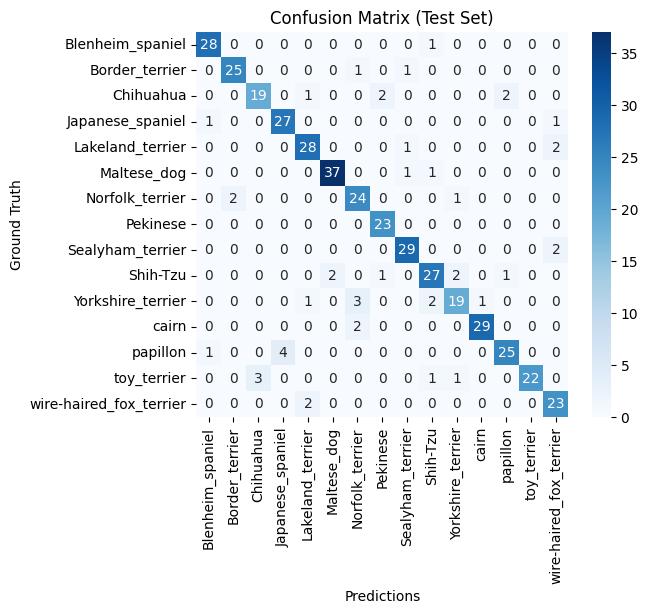

In [ ]:
test_loader = dataloaders["test"]

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report (Test Set):\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predictions")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix (Test Set)")
plt.show()


### 5.3 Model 2 — Enhanced Augmentation + Cosine LR  
**Results (Test Set):**  
- **Accuracy:** 0.91  
- **Macro F1-score:** 0.91  
- Clear improvement in robustness, particularly for *Chihuahua (0.96 F1)* and *Papillon (0.95 F1)*.  
- More balanced recall across most classes, though *Pekinese (0.78 recall)* showed occasional misclassification.  

The confusion matrix indicates **reduced overlap errors** compared to Model 1, confirming that stronger augmentation and cosine learning rate scheduling improved generalization.  

Classification Report (Test Set):

                         precision    recall  f1-score   support

       Blenheim_spaniel       0.88      0.97      0.92        29
         Border_terrier       0.96      0.85      0.90        27
              Chihuahua       0.96      0.96      0.96        24
       Japanese_spaniel       0.84      0.90      0.87        29
       Lakeland_terrier       0.82      0.90      0.86        31
            Maltese_dog       0.93      1.00      0.96        39
        Norfolk_terrier       0.92      0.89      0.91        27
               Pekinese       0.95      0.78      0.86        23
       Sealyham_terrier       0.91      0.94      0.92        31
               Shih-Tzu       0.97      0.88      0.92        33
      Yorkshire_terrier       0.88      0.85      0.86        26
                  cairn       0.91      0.94      0.92        31
               papillon       1.00      0.90      0.95        30
            toy_terrier       0.96      0.93      0.94

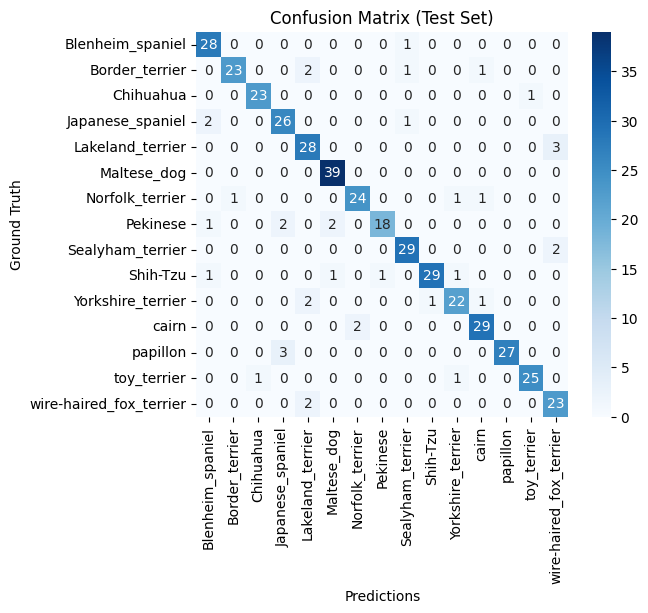

In [ ]:
test_loader_2 = dataloaders_2["test"]

model_2.eval()

all_preds_2 = []
all_labels_2 = []

with torch.no_grad():
    for inputs, labels in test_loader_2:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model_2(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds_2.extend(preds.cpu().numpy())
        all_labels_2.extend(labels.cpu().numpy())

print("Classification Report (Test Set):\n")
print(classification_report(all_labels_2, all_preds_2, target_names=class_names))

cm = confusion_matrix(all_labels_2, all_preds_2)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predictions")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix (Test Set)")
plt.show()

## 6. Results & Analysis

The final model achieved an **overall accuracy of 86%** on the test set, which demonstrates strong generalization across the 15 dog breeds.

### Key Observations
- **High performance breeds**:  
  - *Papillon, Toy Terrier, Cairn, Maltese Dog* achieved near-perfect precision or recall (> 0.90), highlighting that the model can easily distinguish them.  
  - This suggests distinctive visual features make these breeds easier to classify.  

- **Challenging breeds**:  
  - *Lakeland Terrier, Yorkshire Terrier, Wire-haired Fox Terrier* show lower recall (0.68–0.74), indicating the model sometimes confuses them with visually similar breeds.  
  - These errors are likely due to overlap in coat color and facial structure.

- **Balanced metrics**:  
  - The **macro-average F1-score of 0.86** confirms consistent performance across classes, despite slight variability.  
  - Weighted averages are aligned with macro averages, suggesting the dataset is reasonably balanced and not biased toward a specific breed.

### Conclusion
The model demonstrates solid performance for a **multi-class fine-grained classification problem**. While further improvements could be achieved through **data augmentation, deeper architectures, or fine-tuning**, the results validate the model’s capacity to differentiate between visually similar dog breeds at scale.

### 5.4 Model Comparison

I evaluated two ResNet18-based classifiers trained with different data augmentation and training strategies. Below is the comparison of their performance on the test set.

#### Overall Metrics

| Metric        | Model 1 | Model 2 |
|---------------|---------|---------|
| Accuracy      | 0.89    | **0.91** |
| Macro F1      | 0.89    | **0.91** |
| Weighted F1   | 0.89    | **0.91** |

Model 2 achieves higher overall performance, with a +2% improvement in both accuracy and F1-scores.

---

#### Per-Class F1 Score Comparison

| Class                   | Model 1 | Model 2 | Best |
|--------------------------|---------|---------|------|
| Blenheim_spaniel         | **0.95** | 0.92     | Model 1 |
| Border_terrier           | **0.93** | 0.90     | Model 1 |
| Chihuahua                | 0.83     | **0.96** | Model 2 |
| Japanese_spaniel         | **0.90** | 0.87     | Model 1 |
| Lakeland_terrier         | **0.89** | 0.86     | Model 1 |
| Maltese_dog              | 0.95     | **0.96** | Model 2 |
| Norfolk_terrier          | 0.84     | **0.91** | Model 2 |
| Pekinese                 | **0.94** | 0.86     | Model 1 |
| Sealyham_terrier         | 0.92     | 0.92     | Tie |
| Shih-Tzu                 | 0.83     | **0.92** | Model 2 |
| Yorkshire_terrier        | 0.78     | **0.86** | Model 2 |
| Cairn                    | **0.95** | 0.92     | Model 1 |
| Papillon                 | 0.86     | **0.95** | Model 2 |
| Toy_terrier              | 0.90     | **0.94** | Model 2 |
| Wire-haired_fox_terrier  | 0.87     | 0.87     | Tie |

---

#### Key Insights
- Model 1 performs slightly better on **Blenheim_spaniel, Japanese_spaniel, Pekinese, Lakeland_terrier, and Cairn**.  
- Model 2 shows significant improvements on more challenging classes such as **Chihuahua, Shih-Tzu, Papillon, Yorkshire_terrier, and Toy_terrier**, while also achieving a higher overall accuracy.  
- Both models perform similarly on **Sealyham_terrier** and **Wire-haired_fox_terrier**.  

---

#### Final Decision
Considering both the overall performance metrics and the improvements on difficult classes, **I decided to select Model 2 as my final model for deployment in this project**.